# Computational Analysis of Sounds and Music (CH-CASM-M)

## 01 - Fundamentals of Audio Processing (1/2) Part 2

**WS 2025/2026**

Prof. Dr. Jakob Abeßer, jakob.abesser@uni-bamberg.de

Last update: 19.10.2025

**Outline**

In this notebook, you will learn 
 - how to load and process audio files in Python
 - how to sonify and visualize waveforms
 - how to compute and visualize the STFT, Mel Spectrogram, and CQT

In [1]:
!pip install wget

In [2]:
import numpy as np
import wget
import os
import matplotlib
import librosa
%matplotlib inline
import matplotlib.pyplot as pl
import platform
import IPython.display as ipd

### *(Platform-independent Code)*

**HINT**: if you want to write Python scripts that work on multiple platforms (like Windows, Linux etc.), you can use ```platform.platform()``` to figure out automatically, which platform your Python code is run.

In [3]:
# check current platform
print(platform.platform())

# use if/else conditions
if "Windows" in platform.platform():
    dir_audio = 'C:/audio_files'
else:
    dir_audio = '/my_server/audio_files'

Darwin-23.4.0-x86_64-i386-64bit


### Get audio example files

This script loads 2 audio files that we need here.

In [4]:
if not os.path.isfile('piano.wav') or not os.path.isfile('bird.wav'):
    for fn in ('piano.wav', 'bird.wav'):
        wget.download('https://github.com/machinelistening/machinelistening.github.io/blob/master/{}?raw=true'.format(fn), 
                      out=fn, bar=None)
else:
    print('Files already exist!')

### File paths

When working with multiple audio files, it is a good practice to treat directories and filenames separately and use ```os.path.join``` to combine both to absolute filenames. This command uses the correct delimiter signs for all operating systems (Windows, MacOS, Linux).

In [5]:
# 1) define path to the directory that contains the audio files (WAV format)
# TIP: under Windows, it is also recommended to use '/', e.g. 'C:/my_audio_files'
dir_wav = ''  # here, we use the same directory as the notebook is in

# this could also look like
# dir_wav = 'c:/audio_files'

# 2) create absolute path of audio file (directory + filename)
# os.path.join takes care of the correct delimiter signs
# - Linux / MacOSx: "/"
# - Windows: "\\"

fn_wav = os.path.join(dir_wav, 'bird.wav')  # original filename: 416529__inspectorj__bird-whistling-single-robin-a_2s
print(fn_wav)

bird.wav


### Loading audio files

- first check librosa documentation: https://librosa.org/doc/main/generated/librosa.load.html

In [6]:
# (1) use the sample rate of the file, load stereo if needed
x, fs = librosa.load(fn_wav)

print("Sample vector shape:", x.shape)  # 1D numpy array, mono
print("Sample rate [Hz]", fs)
print(f"Audio duration (seconds): {len(x)/fs}")

Sample vector shape: (45476,)
Sample rate [Hz] 22050
Audio duration (seconds): 2.062403628117914


In [7]:
# (2) you could also enforce another sample rate
fs_fix = 44100
x, fs = librosa.load(fn_wav, sr=fs_fix)  # in this case, the signal is upsampled to a higher sample rate

print(x.shape)  # ! increase of sampling rate (upsampling) -> more samples!
print(fs) # ! fix sample rate was used
print(f"Duration = {len(x)/fs} s")

(90951,)
44100
Duration = 2.0623809523809524 s


In [8]:
# (3) if you have a stereo file, you can enforce one channel audio (mono)
# x, fs = librosa.load(fn_wav, mono=True)

### Sonification

Let's listen to our example audio file (birds)

In [9]:
ipd.display(ipd.Audio(data=x, rate=fs))

### Segmentation

Our audio signal is roughly 2.06 s long. Let's extract the first 1.5 seconds of it.

In [10]:
sample_end = int(fs*1.5)
x_first_1_5_s = x[:sample_end]
print(f"Our segment has a duration of {len(x_first_1_5_s)/fs} seconds.")

Our segment has a duration of 1.5 seconds.


### Waveform Visualization

Let's plot our waveform

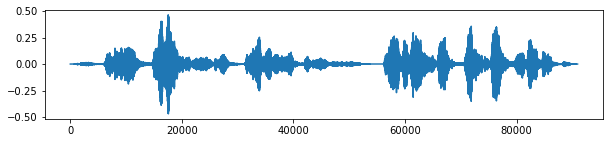

In [11]:
pl.figure(figsize=(10,2))
pl.plot(x)
pl.show()  

**Observation**: the x-axis just shows the sample number so far, this is not informative without the sample rate

#### Create time axis

The sample rate in Hz defines, how many audio samples exist per second. If we compute the inverse ($1/f_\mathrm{s}$), we get the duration of each sample in seconds.

In [12]:
number_of_samples = len(x)
print("Number of samples:", number_of_samples)

seconds_per_sample = 1/fs
print("Duration [seconds] of one sample", seconds_per_sample)  # on audio sample corresponds to ~22.7 ms

# let's create a numpy array with the physical time of each audio sample
frames_in_seconds = np.arange(number_of_samples)*seconds_per_sample
print(frames_in_seconds[:3])

Number of samples: 90951
Duration [seconds] of one sample 2.2675736961451248e-05
[0.00000000e+00 2.26757370e-05 4.53514739e-05]


let's plot the signal again, this time with an interpretable x-axis

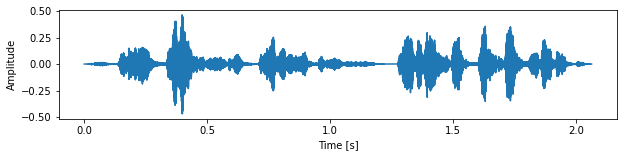

In [13]:

pl.figure(figsize=(10,2))
pl.plot(frames_in_seconds, x)
pl.xlabel('Time [s]')
pl.ylabel('Amplitude')
pl.show()

### Spectrogram using Short-Time Fourier Transform (STFT)

Let's first check the librosa documentation: https://librosa.org/doc/main/generated/librosa.stft.html?highlight=stft#librosa-stft

The most important parameters are 
  - **win_length** - this is the size of our analysis window (in samples)
  - **hop_length** - this is the hop size of our analysis window (in samples), usually this is chosen to be half the window size
  - (**n_fft**) - this is the used "FFT size", which can be bigger than the **win_length** (but should be a power of two, such that the Fast Fourier Transform (FFT) algorithm can be used internally)
  

In [14]:
# Compute the STFT
n_fft = 2048
hop_length = 1024
X = librosa.stft(x, n_fft=n_fft, hop_length=hop_length)  # using the default values: n_fft=2048, 
print("Shape of STFT:", X.shape)  # we get n_fft//2 - 1 bins, the reason is that the STFT has a 
                                  # symmetric structure and we can discard several entries
print("Data type of STFT:", X.dtype)  # ! the STFT is complex and has a magnitude and a phase

# We'll focus on the magnitude of the STFT
S = np.abs(X)
print("Shape of the magnitude spectrogram:", S.shape)
print("Data type of the magnitude spectrogram:", S.dtype)  # ok

Shape of STFT: (1025, 89)
Data type of STFT: complex64
Shape of the magnitude spectrogram: (1025, 89)
Data type of the magnitude spectrogram: float32


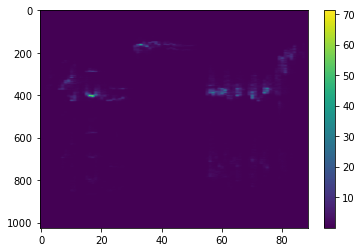

In [15]:
# let's plot it
pl.figure(figsize=(6,4))
pl.imshow(S, aspect="auto")
pl.colorbar()
pl.show()

There a several **problems** with this plot:
  1. the frequency axis is flipped (lower frequencies are shown on top and higher frequencies are shown at the bottom)
  2. only the loudest frequency components are visible  
  3. we want the axes to show the frequency in Hz (y-axis) and the time in seconds (x-axis), at the moment, we only see the frequency bin (y-axis) of the STFT and the frame number (x-axis)


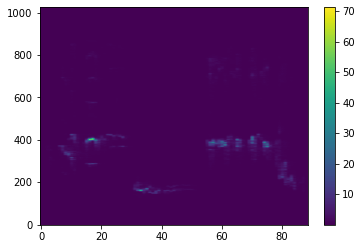

In [16]:
# Issue 1.) use "origin" parameter for imshow()
pl.figure(figsize=(6,4))
pl.imshow(S, aspect="auto", origin="lower")
pl.colorbar()
pl.show()

In [17]:
# Issue 2.) apply logarithmic compression to the magnitude values -> this converts the linear magnitudes to decibels (dB)
S_dB = librosa.amplitude_to_db(S, ref=np.max)

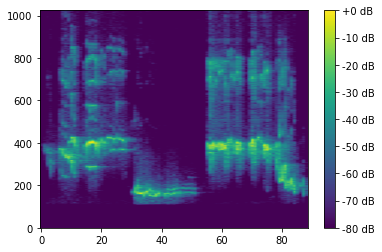

In [18]:
fig = pl.figure(figsize=(6,4))
pl.imshow(S_dB, aspect="auto", origin="lower")
pl.colorbar(format='%+2.0f dB')
pl.show()

**Observation**
1.  also parts with lower magnitudes are now better visible
2.  the value range shifts from [0, 70] to [-80, 0], this is because of the logarithmic compression

In [19]:
# Issue 3.) define maximum frequency, and maximum time value
f_max = fs/2  # Nyquist frequency
t_max = number_of_samples / fs
print(f_max)
print(t_max)

22050.0
2.0623809523809524


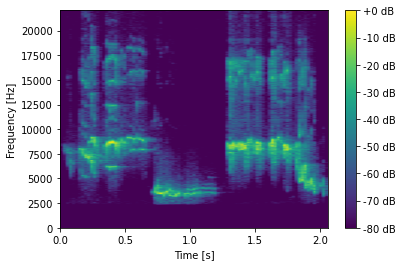

In [20]:
pl.figure(figsize=(6,4))
# use "extent" parameter to define actual range of values along x / y acis
pl.imshow(S_dB, aspect="auto", origin="lower", extent=[0, t_max, 0, f_max])
pl.xlabel('Time [s]')
pl.ylabel('Frequency [Hz]')
pl.colorbar(format='%+2.0f dB')
pl.show()

**Practical Alternative**

As an alternative, we can use the build-in visualization function ```specshow``` of librosa, which allows to visualize STFT spectrograms, Mel spectrograms, and others.

Check the documentation for more info: https://librosa.org/doc/main/generated/librosa.display.specshow.html

AttributeError: module 'librosa' has no attribute 'specshow'

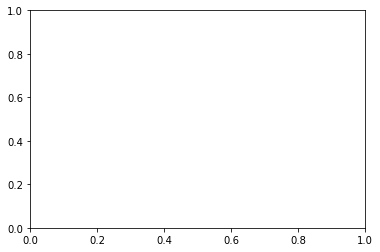

In [22]:
fig, ax = pl.subplots()
# note the keyword "mel", which indicates that a mel frequency axis is used
img = librosa.specshow(S_dB, x_axis='time', y_axis='hz', sr=fs, ax=ax, cmap='viridis')
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='STFT Magnitude Spectrogram (specshow)')
pl.show()

### Mel-Spectrogram

Let's first check the librosa documentation: https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html

The most important parameters are 
  - **y** - audio sample vector ($x$)
  - **sr** - sampling rate of the audio signal (in Hz)
  - **n_mels** - number of Mel frequency bands (commonly: 64 or 128)
  - **win_length** - see above (STFT)
  - **hop_length** - see above (STFT)
  - **n_fft** - see above (STFT)
  

In [ ]:
M = librosa.feature.melspectrogram(y=x, n_fft=2048, hop_length=1024, n_mels=128)  
print("Shape of Mel spectrogram:", M.shape)  # frequency x time: we get n_mels frequency bands

Let's visualize it. We want to
1. convert the time axis (horizontal axis) to seconds (as done before for the STFT)
2. have physical frequency values [Hz] at the vertical axis, that correspond to the 128 mel bands 

In [ ]:
# apply dB compression as before
M_dB = librosa.amplitude_to_db(M, ref=np.max)

In [ ]:
fig, ax = pl.subplots()
# note the keyword "mel", which indicates that a mel frequency axis is used
img = librosa.display.specshow(M_dB, x_axis='time', y_axis='mel', sr=fs, ax=ax, cmap='viridis')
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
pl.show()

### Constant-Q Transform

Let's first check the librosa documentation: https://librosa.org/doc/main/generated/librosa.cqt.html

The most important parameters are 
  - **y** - audio sample vector ($x$)
  - **sr** - sampling rate of the audio signal (in Hz)
  - **hop_length** - see above (STFT)
  - **f_min** - minimum frequency (we can use the default value of 32.70 Hz which corresponds to the note C1)
  - **n_bins** - total number of frequency bins (e.g., for a frequency resolution of one bin per semitone and 4 octaves, this would be 4 * 12 = 48)
  - **bins_per_octave** - Logarithmic frequency resolution (frequency bins per octave, commonly: 12 or 36)
  - **tuning** - Tuning offset (can be used if known tuning frequency of an audio recording deviates from 440 Hz) 
  

We'll now use a short piano recording as running example.

In [ ]:
fn_wav = os.path.join(dir_wav, 'piano.wav')  # original filename: 196765__xserra__piano-phrase.wav
x, fs = librosa.load(fn_wav)
ipd.display(ipd.Audio(data=x, rate=fs))

Let's compute the CQT for a frequency range of 5 octaves with a resolution of 1 bin per semitone (=12 bins per octave)

In [ ]:
n_octaves = 5  # let's capture 5 octaves starting from C1
bins_per_octave = 12  # let's choose a frequency resolution of 100 cent (= one frequency bin per semitone)
C = np.abs(librosa.cqt(x, sr=fs, n_bins=n_octaves*bins_per_octave , bins_per_octave=bins_per_octave))
print("Shape of CQT:", C.shape)  # logically, we get 60 frequency bins

In [ ]:
# dB magnitude scaling
C = librosa.amplitude_to_db(C)

In [ ]:
# we can use again the visualization tool provided by librosa
fig, ax = pl.subplots()
img = librosa.display.specshow(C, sr=fs, x_axis='time', y_axis='cqt_note', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.0f dB")
pl.show()

**Observation**

- the time resolution improves for higher frequencies (see lecture)
- for all pitches, we observe a similar energy pattern along the frequency axis (just shifted vertically according to the pitch)

Now let's do the same for a finer frequency resolution (5 bins per semitone, 60 bins per octave). This will give us finer spectral peaks for the fundamental frequency and the partial frequencies.

If you analyze audio recordings with fundamental frequency modulations (such as vibrato in singing recordings), it's always recommended to use higher frequency resolution.

In [ ]:
bins_per_octave = 50
C = np.abs(librosa.cqt(x, sr=fs, n_bins=n_octaves*bins_per_octave , bins_per_octave=bins_per_octave))
print("Shape of CQT:", C.shape)
C = librosa.amplitude_to_db(C)
fig, ax = pl.subplots()
img = librosa.display.specshow(C, sr=fs, x_axis='time', y_axis='cqt_note', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.0f dB")
pl.show()

Done :)